In [1]:
"""
Schema Change Report Generator
for analyzing PostgreSQL schema changes (Columns & Constraints)
between two timestamps
"""

import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

In [7]:
# ============================================
# DATABASE CONNECTION CONFIGURATION
# ============================================

DB_CONFIG = {
    'host': 'localhost',
    'database': 'test_db',
    'user': 'jagdish_pandre',
    'password': '',
    'port': 5432
}

In [12]:
# ============================================
# TIME RANGE PARAMETERS - MODIFY THESE
# ============================================

START_TIME = '2025-11-14 13:13:01'
END_TIME = '2025-11-14 14:51:46'

In [13]:
# ============================================
# DATABASE CONNECTION
# ============================================

def get_connection():
    """Create database connection"""
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        print("Database connection successful")
        return conn
    except Exception as e:
        print(f"Database connection failed: {e}")
        return None

conn = get_connection()

Database connection successful


In [15]:
# ============================================
# 1. EXECUTIVE SUMMARY
# ============================================

print("="*90)
print("COMPREHENSIVE SCHEMA CHANGE REPORT (Columns & Constraints)")
print(f"Period: {START_TIME} to {END_TIME}")
print("="*90)

query_executive_summary = """
WITH column_summary AS (
    SELECT 
        COUNT(DISTINCT snapshot_id) as total_snapshots,
        COUNT(DISTINCT schema_name) as schemas_affected,
        COUNT(DISTINCT object_type_name) as tables_affected,
        COUNT(DISTINCT object_subtype_name) as columns_affected,
        COUNT(*) as total_column_changes
    FROM pdcd_schema.md5_metadata_tbl
    WHERE processed_time BETWEEN %s AND %s
        AND object_type = 'Table'
        AND object_subtype = 'Column'
),
constraint_summary AS (
    SELECT 
        COUNT(DISTINCT object_type_name) as tables_with_constraint_changes,
        COUNT(DISTINCT object_subtype_name) as constraints_affected,
        COUNT(*) as total_constraint_changes
    FROM pdcd_schema.md5_metadata_tbl
    WHERE processed_time BETWEEN %s AND %s
        AND object_subtype IN ('Primary Key', 'Foreign Key', 'Unique', 'Check')
)
SELECT 
    cs.total_snapshots,
    cs.schemas_affected,
    cs.tables_affected,
    cs.columns_affected,
    cs.total_column_changes,
    cst.tables_with_constraint_changes,
    cst.constraints_affected,
    cst.total_constraint_changes,
    cs.total_column_changes + cst.total_constraint_changes as grand_total_changes
FROM column_summary cs, constraint_summary cst;
"""

df_summary = pd.read_sql_query(query_executive_summary, conn, 
                                params=(START_TIME, END_TIME, START_TIME, END_TIME))

print("\n📊 EXECUTIVE SUMMARY")
print("-" * 90)
for col in df_summary.columns:
    print(f"{col.replace('_', ' ').title()}: {df_summary[col].iloc[0]}")

COMPREHENSIVE SCHEMA CHANGE REPORT (Columns & Constraints)
Period: 2025-11-14 13:13:01 to 2025-11-14 14:51:46

📊 EXECUTIVE SUMMARY
------------------------------------------------------------------------------------------
Total Snapshots: 5
Schemas Affected: 1
Tables Affected: 2
Columns Affected: 6
Total Column Changes: 15
Tables With Constraint Changes: 0
Constraints Affected: 0
Total Constraint Changes: 0
Grand Total Changes: 15



📈 CHANGE TYPE BREAKDOWN (Columns & Constraints)
------------------------------------------------------------------------------------------
object_category change_type  count  percentage
         Column    MODIFIED      8       27.59
         Column       ADDED      7       24.14
          Other       ADDED      8       27.59
          Other     DELETED      4       13.79
          Other    MODIFIED      2        6.90


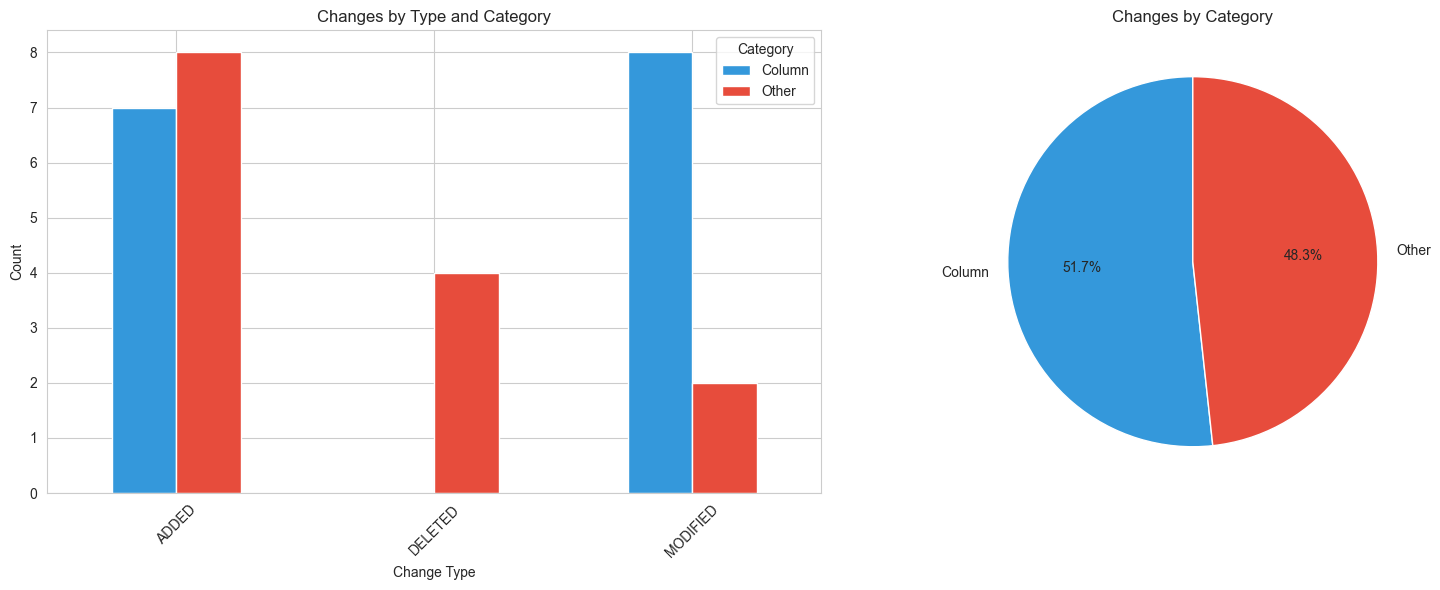

In [16]:
# ============================================
# 2. CHANGE TYPE BREAKDOWN (Combined)
# ============================================

query_change_breakdown = """
SELECT 
    CASE 
        WHEN object_subtype = 'Column' THEN 'Column'
        WHEN object_subtype IN ('Primary Key', 'Foreign Key', 'Unique', 'Check') THEN 'Constraint'
        ELSE 'Other'
    END as object_category,
    change_type,
    COUNT(*) as count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) as percentage
FROM pdcd_schema.md5_metadata_tbl
WHERE processed_time BETWEEN %s AND %s
GROUP BY object_category, change_type
ORDER BY object_category, count DESC;
"""

df_change_types = pd.read_sql_query(query_change_breakdown, conn, params=(START_TIME, END_TIME))

print("\n📈 CHANGE TYPE BREAKDOWN (Columns & Constraints)")
print("-" * 90)
print(df_change_types.to_string(index=False))

# Visualization
if not df_change_types.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Grouped bar chart by category and change type
    pivot_data = df_change_types.pivot(index='change_type', columns='object_category', values='count').fillna(0)
    pivot_data.plot(kind='bar', ax=ax1, color=['#3498db', '#e74c3c'])
    ax1.set_xlabel('Change Type')
    ax1.set_ylabel('Count')
    ax1.set_title('Changes by Type and Category')
    ax1.legend(title='Category')
    ax1.tick_params(axis='x', rotation=45)
    
    # Pie chart for overall distribution
    category_totals = df_change_types.groupby('object_category')['count'].sum()
    colors = ['#3498db', '#e74c3c', '#95a5a6']
    ax2.pie(category_totals.values, labels=category_totals.index, 
            autopct='%1.1f%%', colors=colors, startangle=90)
    ax2.set_title('Changes by Category')
    
    plt.tight_layout()
    plt.show()


📋 CHANGES BY TABLE
------------------------------------------------------------------------------------------
     schema_name  table_name  column_changes  constraint_changes  total_changes  added  modified  deleted  renamed
analytics_schema departments               7                   0             15      7         5        3        0
analytics_schema   employees               8                   0             14      8         5        1        0


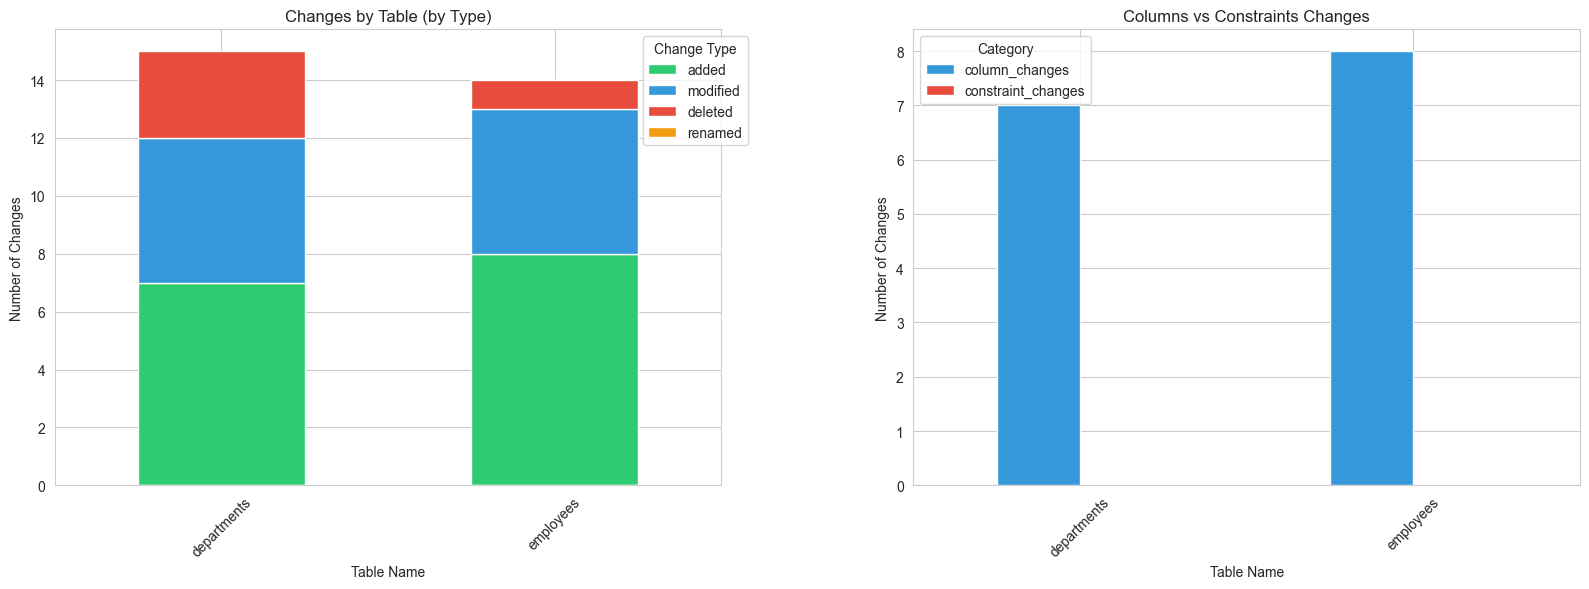

In [18]:
# ============================================
# 3. CHANGES BY TABLE
# ============================================

query_changes_by_table = """
SELECT 
    schema_name,
    object_type_name as table_name,
    COUNT(*) FILTER (WHERE object_subtype = 'Column') as column_changes,
    COUNT(*) FILTER (WHERE object_subtype IN ('Primary Key', 'Foreign Key', 'Unique', 'Check')) as constraint_changes,
    COUNT(*) as total_changes,
    COUNT(*) FILTER (WHERE change_type = 'ADDED') as added,
    COUNT(*) FILTER (WHERE change_type = 'MODIFIED') as modified,
    COUNT(*) FILTER (WHERE change_type = 'DELETED') as deleted,
    COUNT(*) FILTER (WHERE change_type = 'RENAMED') as renamed
FROM pdcd_schema.md5_metadata_tbl
WHERE processed_time BETWEEN %s AND %s
GROUP BY schema_name, object_type_name
ORDER BY total_changes DESC;
"""

df_by_table = pd.read_sql_query(query_changes_by_table, conn, params=(START_TIME, END_TIME))

print("\n📋 CHANGES BY TABLE")
print("-" * 90)
print(df_by_table.to_string(index=False))

# Visualization
if not df_by_table.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Stacked bar for change types
    df_plot1 = df_by_table.set_index('table_name')[['added', 'modified', 'deleted', 'renamed']]
    df_plot1.plot(kind='bar', stacked=True, ax=ax1, 
                  color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'])
    ax1.set_xlabel('Table Name')
    ax1.set_ylabel('Number of Changes')
    ax1.set_title('Changes by Table (by Type)')
    ax1.legend(title='Change Type', bbox_to_anchor=(1.05, 1))
    ax1.tick_params(axis='x', rotation=45)
    
    # Grouped bar for columns vs constraints
    df_plot2 = df_by_table.set_index('table_name')[['column_changes', 'constraint_changes']]
    df_plot2.plot(kind='bar', ax=ax2, color=['#3498db', '#e74c3c'])
    ax2.set_xlabel('Table Name')
    ax2.set_ylabel('Number of Changes')
    ax2.set_title('Columns vs Constraints Changes')
    ax2.legend(title='Category')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

In [19]:
# ============================================
# 4. DETAILED COLUMN ADDITIONS
# ============================================

query_additions = """
SELECT 
    snapshot_id,
    processed_time,
    schema_name,
    object_type_name as table_name,
    object_subtype_name as column_name,
    REGEXP_REPLACE(object_subtype_details, '.*data_type:([^,]+).*', '\\1') as data_type,
    REGEXP_REPLACE(object_subtype_details, '.*max_length:([^,]*),.*', '\\1') as max_length,
    REGEXP_REPLACE(object_subtype_details, '.*nullable:([^,]+).*', '\\1') as nullable,
    REGEXP_REPLACE(object_subtype_details, '.*default_value:([^,]*),.*', '\\1') as default_value,
    REGEXP_REPLACE(object_subtype_details, '.*ordinal_position:([0-9]+).*', '\\1') as position
FROM pdcd_schema.md5_metadata_tbl
WHERE processed_time BETWEEN %s AND %s
    AND change_type = 'ADDED'
    AND object_subtype = 'Column'
ORDER BY processed_time, schema_name, object_type_name;
"""

df_additions = pd.read_sql_query(query_additions, conn, params=(START_TIME, END_TIME))

print("\n➕ COLUMN ADDITIONS")
print("-" * 90)
if df_additions.empty:
    print("No columns added in this period.")
else:
    print(df_additions.to_string(index=False))


➕ COLUMN ADDITIONS
------------------------------------------------------------------------------------------
 snapshot_id             processed_time      schema_name  table_name     column_name         data_type max_length nullable                                                       default_value position
           1 2025-11-14 13:13:01.047559 analytics_schema departments   department_id           integer                  NO nextval('analytics_schema.departments_department_id_seq'::regclass)        1
           1 2025-11-14 13:13:01.053514 analytics_schema departments department_name character varying        100       NO                                                                            2
           1 2025-11-14 13:13:01.053536 analytics_schema departments     budget_code character varying         20      YES                                                                            3
           1 2025-11-14 13:13:01.053542 analytics_schema   employees     employee_id     

In [20]:
# ============================================
# 5. DETAILED COLUMN MODIFICATIONS
# ============================================

query_modifications = """
WITH current_changes AS (
    SELECT 
        snapshot_id,
        processed_time,
        schema_name,
        object_type_name,
        object_subtype_name,
        object_subtype_details,
        object_md5
    FROM pdcd_schema.md5_metadata_tbl
    WHERE processed_time BETWEEN %s AND %s
        AND change_type = 'MODIFIED'
        AND object_subtype = 'Column'
),
previous_state AS (
    SELECT DISTINCT ON (cc.schema_name, cc.object_type_name, cc.object_subtype_name)
        cc.schema_name,
        cc.object_type_name,
        cc.object_subtype_name,
        m.object_subtype_details as old_details
    FROM current_changes cc
    JOIN pdcd_schema.md5_metadata_tbl m 
        ON cc.schema_name = m.schema_name 
        AND cc.object_type_name = m.object_type_name
        AND cc.object_subtype_name = m.object_subtype_name
        AND m.processed_time < cc.processed_time
    ORDER BY cc.schema_name, cc.object_type_name, cc.object_subtype_name, m.processed_time DESC
)
SELECT 
    cc.snapshot_id,
    cc.processed_time,
    cc.schema_name,
    cc.object_type_name as table_name,
    cc.object_subtype_name as column_name,
    REGEXP_REPLACE(ps.old_details, '.*data_type:([^,]+).*', '\\1') as old_data_type,
    REGEXP_REPLACE(cc.object_subtype_details, '.*data_type:([^,]+).*', '\\1') as new_data_type,
    REGEXP_REPLACE(ps.old_details, '.*max_length:([^,]*),.*', '\\1') as old_max_length,
    REGEXP_REPLACE(cc.object_subtype_details, '.*max_length:([^,]*),.*', '\\1') as new_max_length,
    REGEXP_REPLACE(ps.old_details, '.*nullable:([^,]+).*', '\\1') as old_nullable,
    REGEXP_REPLACE(cc.object_subtype_details, '.*nullable:([^,]+).*', '\\1') as new_nullable,
    REGEXP_REPLACE(ps.old_details, '.*default_value:([^,]*),.*', '\\1') as old_default,
    REGEXP_REPLACE(cc.object_subtype_details, '.*default_value:([^,]*),.*', '\\1') as new_default
FROM current_changes cc
LEFT JOIN previous_state ps 
    ON cc.schema_name = ps.schema_name 
    AND cc.object_type_name = ps.object_type_name
    AND cc.object_subtype_name = ps.object_subtype_name
ORDER BY cc.processed_time, cc.schema_name, cc.object_type_name;
"""

df_modifications = pd.read_sql_query(query_modifications, conn, params=(START_TIME, END_TIME))

print("\n✏️ COLUMN MODIFICATIONS")
print("-" * 90)
if df_modifications.empty:
    print("No columns modified in this period.")
else:
    changes = []
    for _, row in df_modifications.iterrows():
        change_desc = []
        if pd.notna(row['old_data_type']) and row['old_data_type'] != row['new_data_type']:
            change_desc.append(f"Type: {row['old_data_type']} → {row['new_data_type']}")
        if (pd.notna(row['old_max_length']) and 
            row['old_max_length'] != row['new_max_length'] and row['new_max_length'] != ''):
            change_desc.append(f"Length: {row['old_max_length']} → {row['new_max_length']}")
        if pd.notna(row['old_nullable']) and row['old_nullable'] != row['new_nullable']:
            change_desc.append(f"Nullable: {row['old_nullable']} → {row['new_nullable']}")
        if pd.notna(row['old_default']) and row['old_default'] != row['new_default']:
            old_def = row['old_default'] if row['old_default'] else 'NULL'
            new_def = row['new_default'] if row['new_default'] else 'NULL'
            change_desc.append(f"Default: {old_def} → {new_def}")
        changes.append('; '.join(change_desc) if change_desc else 'Other changes')
    
    df_modifications['changes'] = changes
    print(df_modifications[['processed_time', 'table_name', 'column_name', 'changes']].to_string(index=False))


✏️ COLUMN MODIFICATIONS
------------------------------------------------------------------------------------------
            processed_time  table_name     column_name            changes
2025-11-14 13:13:55.925285 departments department_name      Other changes
2025-11-14 13:13:55.925338   employees   department_id      Other changes
2025-11-14 13:13:55.925344   employees      first_name Nullable: YES → NO
2025-11-14 13:48:46.043964 departments department_name      Other changes
2025-11-14 13:48:46.044021   employees   department_id      Other changes
2025-11-14 14:46:58.994843 departments department_name      Other changes
2025-11-14 14:46:58.994875   employees   department_id      Other changes
2025-11-14 14:51:45.474365 departments department_name      Other changes


In [21]:
# ============================================
# 6. COLUMN DELETIONS
# ============================================

query_deletions = """
SELECT 
    snapshot_id,
    processed_time,
    schema_name,
    object_type_name as table_name,
    object_subtype_name as column_name,
    REGEXP_REPLACE(object_subtype_details, '.*data_type:([^,]+).*', '\\1') as data_type
FROM pdcd_schema.md5_metadata_tbl
WHERE processed_time BETWEEN %s AND %s
    AND change_type = 'DELETED'
    AND object_subtype = 'Column'
ORDER BY processed_time, schema_name, object_type_name;
"""

df_deletions = pd.read_sql_query(query_deletions, conn, params=(START_TIME, END_TIME))

print("\n❌ COLUMN DELETIONS")
print("-" * 90)
if df_deletions.empty:
    print("No columns deleted in this period.")
else:
    print(df_deletions.to_string(index=False))


❌ COLUMN DELETIONS
------------------------------------------------------------------------------------------
No columns deleted in this period.


In [ ]:
# ============================================
# 7. COLUMN RENAMES
# ============================================

query_renames = """
WITH renames AS (
    SELECT 
        snapshot_id,
        processed_time,
        schema_name,
        object_type_name,
        object_subtype_name as new_name,
        object_md5
    FROM pdcd_schema.md5_metadata_tbl
    WHERE processed_time BETWEEN %s AND %s
        AND change_type = 'RENAMED'
        AND object_subtype = 'Column'
)
SELECT 
    r.snapshot_id,
    r.processed_time,
    r.schema_name,
    r.object_type_name as table_name,
    COALESCE(
        (SELECT m.object_subtype_name 
         FROM pdcd_schema.md5_metadata_tbl m
         WHERE m.schema_name = r.schema_name
           AND m.object_type_name = r.object_type_name
           AND m.object_md5 = r.object_md5
           AND m.processed_time < r.processed_time
           AND m.change_type != 'RENAMED'
         ORDER BY m.processed_time DESC
         LIMIT 1), 
        '(unknown)'
    ) as old_name,
    r.new_name
FROM renames r
ORDER BY processed_time, schema_name, object_type_name;
"""

df_col_renames = pd.read_sql_query(query_renames, conn, params=(START_TIME, END_TIME))

print("\nCOLUMN RENAMES")
print("-" * 90)
if df_col_renames.empty:
    print("No columns renamed in this period.")
else:
    print(df_col_renames.to_string(index=False))


🔄 COLUMN RENAMES
------------------------------------------------------------------------------------------
No columns renamed in this period.


In [24]:
# ============================================
# 8. CONSTRAINT ADDITIONS
# ============================================

query_constraint_additions = """
SELECT 
    snapshot_id,
    processed_time,
    schema_name,
    object_type_name as table_name,
    object_subtype as constraint_type,
    object_subtype_name as constraint_name
FROM pdcd_schema.md5_metadata_tbl
WHERE processed_time BETWEEN %s AND %s
    AND change_type = 'ADDED'
    AND object_subtype IN ('Primary Key', 'Foreign Key', 'Unique', 'Check')
ORDER BY processed_time, schema_name, object_type_name;
"""

df_constraint_additions = pd.read_sql_query(query_constraint_additions, conn, params=(START_TIME, END_TIME))

print("\n🔐 CONSTRAINT ADDITIONS")
print("-" * 90)
if df_constraint_additions.empty:
    print("No constraints added in this period.")
else:
    print(df_constraint_additions.to_string(index=False))


🔐 CONSTRAINT ADDITIONS
------------------------------------------------------------------------------------------
No constraints added in this period.


In [25]:
# ============================================
# 9. CONSTRAINT DELETIONS
# ============================================

query_constraint_deletions = """
SELECT 
    snapshot_id,
    processed_time,
    schema_name,
    object_type_name as table_name,
    object_subtype as constraint_type,
    object_subtype_name as constraint_name
FROM pdcd_schema.md5_metadata_tbl
WHERE processed_time BETWEEN %s AND %s
    AND change_type = 'DELETED'
    AND object_subtype IN ('Primary Key', 'Foreign Key', 'Unique', 'Check')
ORDER BY processed_time, schema_name, object_type_name;
"""

df_constraint_deletions = pd.read_sql_query(query_constraint_deletions, conn, params=(START_TIME, END_TIME))

print("\n🗑️ CONSTRAINT DELETIONS")
print("-" * 90)
if df_constraint_deletions.empty:
    print("No constraints deleted in this period.")
else:
    print(df_constraint_deletions.to_string(index=False))


🗑️ CONSTRAINT DELETIONS
------------------------------------------------------------------------------------------
No constraints deleted in this period.



📅 CHRONOLOGICAL TIMELINE (Columns & Constraints)
------------------------------------------------------------------------------------------
            processed_time  snapshot_id  table_name                                         description
2025-11-14 13:13:01.047559            1 departments             ➕ Added Column: department_id (integer)
2025-11-14 13:13:01.053514            1 departments ➕ Added Column: department_name (character varying)
2025-11-14 13:13:01.053536            1 departments     ➕ Added Column: budget_code (character varying)
2025-11-14 13:13:01.053542            1   employees               ➕ Added Column: employee_id (integer)
2025-11-14 13:13:01.053546            1   employees      ➕ Added Column: first_name (character varying)
2025-11-14 13:13:01.053551            1   employees       ➕ Added Column: last_name (character varying)
2025-11-14 13:13:01.053555            1   employees             ➕ Added Column: department_id (integer)
2025-11-14 13:13:01.055954 

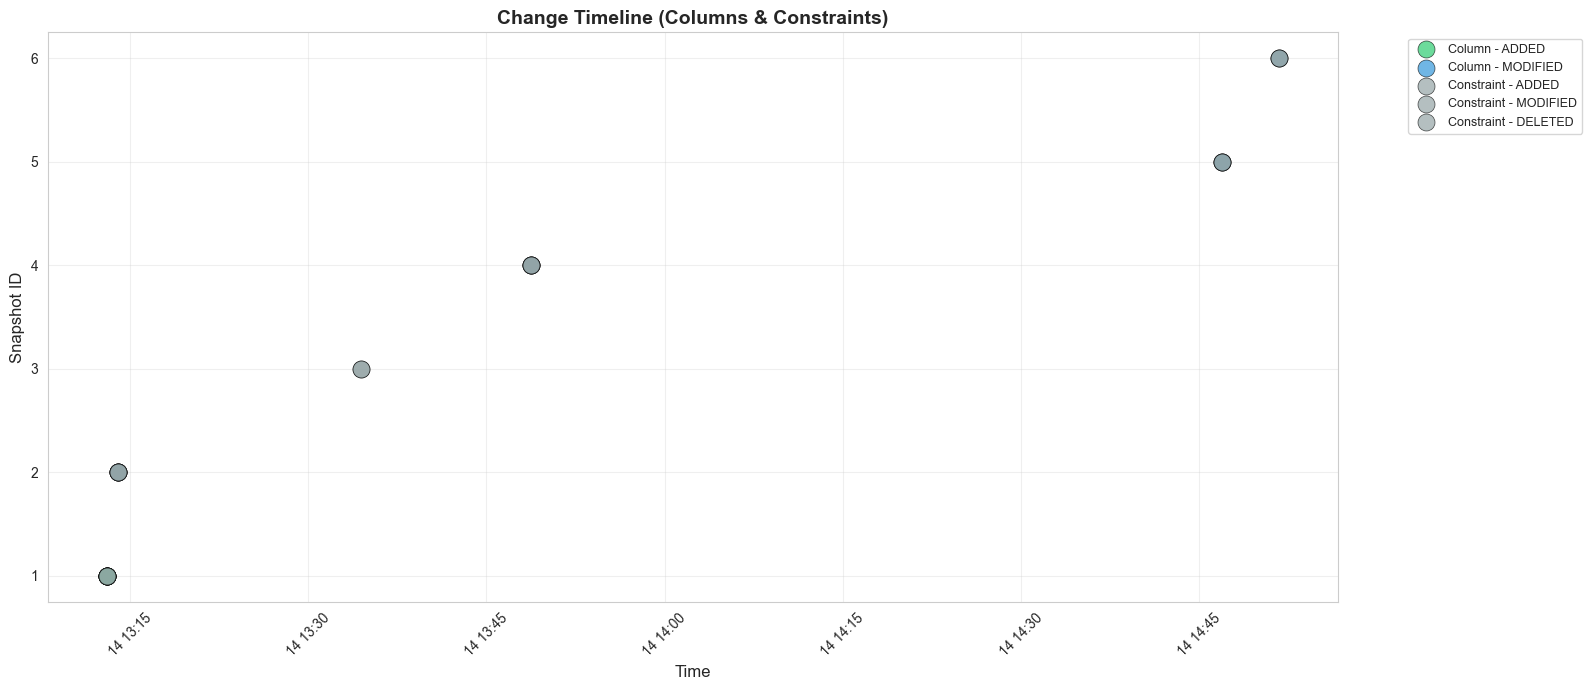

In [26]:
# ============================================
# 10. CHRONOLOGICAL TIMELINE (Enhanced)
# ============================================

query_timeline = """
WITH timeline_data AS (
    SELECT 
        m1.snapshot_id,
        m1.processed_time,
        m1.schema_name,
        m1.object_type_name as table_name,
        m1.object_subtype,
        m1.object_subtype_name as object_name,
        m1.change_type,
        m1.object_subtype_details as current_details,
        m1.object_md5,
        (SELECT m2.object_subtype_name 
         FROM pdcd_schema.md5_metadata_tbl m2
         WHERE m2.schema_name = m1.schema_name
           AND m2.object_type_name = m1.object_type_name
           AND m2.object_md5 = m1.object_md5
           AND m2.processed_time < m1.processed_time
           AND m2.change_type != 'RENAMED'
         ORDER BY m2.processed_time DESC
         LIMIT 1
        ) as previous_name,
        (SELECT m3.object_subtype_details
         FROM pdcd_schema.md5_metadata_tbl m3
         WHERE m3.schema_name = m1.schema_name
           AND m3.object_type_name = m1.object_type_name
           AND m3.object_subtype_name = m1.object_subtype_name
           AND m3.processed_time < m1.processed_time
         ORDER BY m3.processed_time DESC
         LIMIT 1
        ) as previous_details
    FROM pdcd_schema.md5_metadata_tbl m1
    WHERE m1.processed_time BETWEEN %s AND %s
)
SELECT 
    snapshot_id,
    processed_time,
    schema_name,
    table_name,
    object_subtype,
    object_name,
    change_type,
    previous_name,
    REGEXP_REPLACE(current_details, '.*data_type:([^,]+).*', '\\1') as current_data_type,
    REGEXP_REPLACE(previous_details, '.*data_type:([^,]+).*', '\\1') as previous_data_type,
    REGEXP_REPLACE(current_details, '.*max_length:([^,]*),.*', '\\1') as current_max_length,
    REGEXP_REPLACE(previous_details, '.*max_length:([^,]*),.*', '\\1') as previous_max_length,
    REGEXP_REPLACE(current_details, '.*nullable:([^,]+).*', '\\1') as current_nullable,
    REGEXP_REPLACE(previous_details, '.*nullable:([^,]+).*', '\\1') as previous_nullable
FROM timeline_data
ORDER BY processed_time, snapshot_id, schema_name, table_name;
"""

df_timeline = pd.read_sql_query(query_timeline, conn, params=(START_TIME, END_TIME))

print("\n📅 CHRONOLOGICAL TIMELINE (Columns & Constraints)")
print("-" * 90)
if df_timeline.empty:
    print("No changes in this period.")
else:
    descriptions = []
    for _, row in df_timeline.iterrows():
        if row['object_subtype'] == 'Column':
            if row['change_type'] == 'ADDED':
                desc = f"➕ Added Column: {row['object_name']} ({row['current_data_type']})"
            elif row['change_type'] == 'MODIFIED':
                changes = []
                if pd.notna(row['previous_data_type']) and row['previous_data_type'] != row['current_data_type']:
                    changes.append(f"Type: {row['previous_data_type']} → {row['current_data_type']}")
                if (pd.notna(row['previous_max_length']) and 
                    row['previous_max_length'] != row['current_max_length'] and 
                    row['current_max_length'] != ''):
                    changes.append(f"Length: {row['previous_max_length']} → {row['current_max_length']}")
                if pd.notna(row['previous_nullable']) and row['previous_nullable'] != row['current_nullable']:
                    changes.append(f"Nullable: {row['previous_nullable']} → {row['current_nullable']}")
                change_detail = ', '.join(changes) if changes else 'Other changes'
                desc = f"✏️ Modified Column: {row['object_name']} - {change_detail}"
            elif row['change_type'] == 'DELETED':
                desc = f"❌ Deleted Column: {row['object_name']} ({row['current_data_type']})"
            elif row['change_type'] == 'RENAMED':
                old_name = row['previous_name'] if pd.notna(row['previous_name']) else '(unknown)'
                desc = f"🔄 Renamed Column: {old_name} → {row['object_name']}"
            else:
                desc = f"{row['change_type']}: {row['object_name']}"
        elif row['object_subtype'] in ['Primary Key', 'Foreign Key', 'Unique', 'Check']:
            emoji = {'ADDED': '🔐', 'MODIFIED': '🔧', 'DELETED': '🗑️', 'RENAMED': '🔄'}
            e = emoji.get(row['change_type'], '📌')
            if row['change_type'] == 'RENAMED':
                old_name = row['previous_name'] if pd.notna(row['previous_name']) else '(unknown)'
                desc = f"{e} Renamed {row['object_subtype']}: {old_name} → {row['object_name']}"
            else:
                desc = f"{e} {row['change_type']} {row['object_subtype']}: {row['object_name']}"
        else:
            desc = f"{row['change_type']}: {row['object_name']}"
        
        descriptions.append(desc)
    
    df_timeline['description'] = descriptions
    display_cols = ['processed_time', 'snapshot_id', 'table_name', 'description']
    print(df_timeline[display_cols].to_string(index=False))

# Visualization - Timeline
if not df_timeline.empty:
    fig, ax = plt.subplots(figsize=(16, 7))
    
    df_timeline['time_numeric'] = pd.to_datetime(df_timeline['processed_time'])
    
    # Color mapping
    color_map = {
        'Column': {'ADDED': '#2ecc71', 'MODIFIED': '#3498db', 'DELETED': '#e74c3c', 'RENAMED': '#f39c12'},
        'Primary Key': {'ADDED': '#9b59b6', 'MODIFIED': '#8e44ad', 'DELETED': '#c0392b', 'RENAMED': '#d35400'},
        'Foreign Key': {'ADDED': '#1abc9c', 'MODIFIED': '#16a085', 'DELETED': '#c0392b', 'RENAMED': '#d35400'},
        'Unique': {'ADDED': '#34495e', 'MODIFIED': '#2c3e50', 'DELETED': '#c0392b', 'RENAMED': '#d35400'},
        'Check': {'ADDED': '#95a5a6', 'MODIFIED': '#7f8c8d', 'DELETED': '#c0392b', 'RENAMED': '#d35400'}
    }
    
    for obj_type in df_timeline['object_subtype'].unique():
        for change_type in df_timeline['change_type'].unique():
            subset = df_timeline[(df_timeline['object_subtype'] == obj_type) & 
                                (df_timeline['change_type'] == change_type)]
            if not subset.empty:
                color = color_map.get(obj_type, {}).get(change_type, '#95a5a6')
                ax.scatter(subset['time_numeric'], subset['snapshot_id'], 
                          label=f'{obj_type} - {change_type}', 
                          s=150, alpha=0.7, color=color, edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Snapshot ID', fontsize=12)
    ax.set_title('Change Timeline (Columns & Constraints)', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [27]:
# ============================================
# 11. HIGH-RISK CHANGES
# ============================================

query_high_risk = """
SELECT 
    processed_time,
    schema_name,
    object_type_name as table_name,
    object_subtype as object_type,
    object_subtype_name as object_name,
    change_type,
    CASE 
        WHEN change_type = 'DELETED' AND object_subtype = 'Column' 
            THEN '🔴 CRITICAL: Column deleted - potential data loss'
        WHEN change_type = 'DELETED' AND object_subtype = 'Primary Key' 
            THEN '🔴 CRITICAL: Primary key deleted - data integrity at risk'
        WHEN change_type = 'DELETED' AND object_subtype = 'Foreign Key' 
            THEN '🔴 CRITICAL: Foreign key deleted - referential integrity lost'
        WHEN change_type = 'MODIFIED' AND object_subtype = 'Column' 
            THEN '🟡 MEDIUM: Column modified - verify data compatibility'
        WHEN change_type = 'MODIFIED' AND object_subtype IN ('Primary Key', 'Foreign Key', 'Unique') 
            THEN '🟠 HIGH: Constraint modified - may break existing data'
        WHEN change_type = 'RENAMED' AND object_subtype = 'Column' 
            THEN '🟡 MEDIUM: Column renamed - update application code'
        WHEN change_type = 'ADDED' AND object_subtype IN ('Primary Key', 'Unique') 
            THEN '🟡 MEDIUM: New constraint added - verify existing data'
        ELSE '🟢 LOW: Standard change'
    END as risk_level
FROM pdcd_schema.md5_metadata_tbl
WHERE processed_time BETWEEN %s AND %s
    AND (change_type IN ('DELETED', 'MODIFIED', 'RENAMED') 
         OR (change_type = 'ADDED' AND object_subtype IN ('Primary Key', 'Unique', 'Foreign Key')))
ORDER BY 
    CASE 
        WHEN change_type = 'DELETED' AND object_subtype IN ('Primary Key', 'Column') THEN 1
        WHEN change_type = 'DELETED' AND object_subtype = 'Foreign Key' THEN 2
        WHEN change_type = 'MODIFIED' THEN 3
        ELSE 4
    END,
    processed_time;
"""

df_high_risk = pd.read_sql_query(query_high_risk, conn, params=(START_TIME, END_TIME))

print("\n⚠️ HIGH-RISK CHANGES")
print("-" * 90)
if df_high_risk.empty:
    print("No high-risk changes detected.")
else:
    print(df_high_risk.to_string(index=False))


⚠️ HIGH-RISK CHANGES
------------------------------------------------------------------------------------------
            processed_time      schema_name  table_name object_type         object_name change_type                                            risk_level
2025-11-14 13:13:55.925285 analytics_schema departments      Column     department_name    MODIFIED 🟡 MEDIUM: Column modified - verify data compatibility
2025-11-14 13:13:55.925338 analytics_schema   employees      Column       department_id    MODIFIED 🟡 MEDIUM: Column modified - verify data compatibility
2025-11-14 13:13:55.925344 analytics_schema   employees      Column          first_name    MODIFIED 🟡 MEDIUM: Column modified - verify data compatibility
2025-11-14 13:34:23.498988 analytics_schema departments  Constraint     chk_budget_code    MODIFIED                                🟢 LOW: Standard change
2025-11-14 13:34:23.499048 analytics_schema   employees  Constraint         fk_emp_dept    MODIFIED                  